In [2]:
from boxoffice.db.frames import get_wikipedia_day_frame, get_movie_frame_full

wdf = get_wikipedia_day_frame()
mdf = get_movie_frame_full()

movies.csv exists, 1730247204.052078, 1730247534.3474545
movies.csv is out of date, recalculating
SELECT "t1"."id", "t1"."truncated_title", "t1"."slug", "t1"."title", "t1"."release_year", "t1"."mpaa_rating", "t1"."running_time", "t1"."synopsis", "t1"."mpaa_rating_reason", "t1"."budget", "t1"."creative_type", "t1"."genre", "t1"."production_method", "t1"."source", "t1"."poster", SUM("t2"."revenue") AS "total_box_office", MIN("t2"."date") AS "release_day", "t3"."distributor_id" AS "distributor_id", "t4"."franchise_id" AS "franchise_id", "t5"."name" AS "distributor_name", "t5"."slug" AS "distributor_slug", "t6"."name" AS "franchise_name", "t6"."slug" AS "franchise_slug", "t7"."release_day_non_preview", "t7"."largest_theater_count", "t8"."days_over_1000_theaters", "t9"."days_over_1000000_revenue", "t10"."days_over_100000_revenue", "t11"."preview_sum" FROM "movie" AS "t1" INNER JOIN "boxofficeday" AS "t2" ON ("t1"."id" = "t2"."movie_id") INNER JOIN "moviedistributor" AS "t3" ON ("t3"."movie_

/home/ag/.pyenv/versions/3.12.5/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ag/.pyenv/versions/3.12.5/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Columns in wikipedia_df: Index(['id_x', 'date', 'views', 'movie', 'release_day',
       'release_day_non_preview', 'release_day_first_friday', 'id_y'],
      dtype='object')
cumulative_views: 912, wikipedia_pre_release_cumulative_views: 882, wikipedia_pre_release_monday_views: 880, wikipedia_pre_release_week_monday: 879, wikipedia_pre_release_three_monday: 879, cumulative index: 912
Columns in merged_accumulated: Index(['movie_id', 'wikipedia_pre_release_three_monday', 'movie_2',
       'wikipedia_pre_release_week_monday',
       'wikipedia_pre_release_monday_views',
       'wikipedia_pre_release_cumulative_views', 'wikipedia_cumulative_views'],
      dtype='object')


In [25]:
# want to get the correlation between wikipedia views on any given day and the opening wide weekend box office for a film
# within wdf, create a new column that is the index of the day with respect to the movie
unique_movies = wdf['movie'].unique()

corr_wdf = wdf.copy(deep=True)

corr_wdf['day_index'] = 0
corr_wdf['opening_wide_revenue'] = 0

for movie in unique_movies:
    movie_wdf = wdf[wdf['movie'] == movie]
    movie_wdf =  movie_wdf.sort_values(by='date')
    movie_wdf = movie_wdf.reset_index(drop=True)
    movie_mdf = mdf[mdf['id'] == movie]
    if len(movie_mdf) == 0:
        continue
    # now write this back to the main dataframe
    corr_wdf.loc[corr_wdf['movie'] == movie, 'day_index'] = movie_wdf.index
    corr_wdf.loc[corr_wdf['movie'] == movie, 'opening_wide_revenue'] = movie_mdf['opening_wide_revenue'].values[0]

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Text(0, 0.5, 'Correlation between wikipedia views and opening wide revenue')

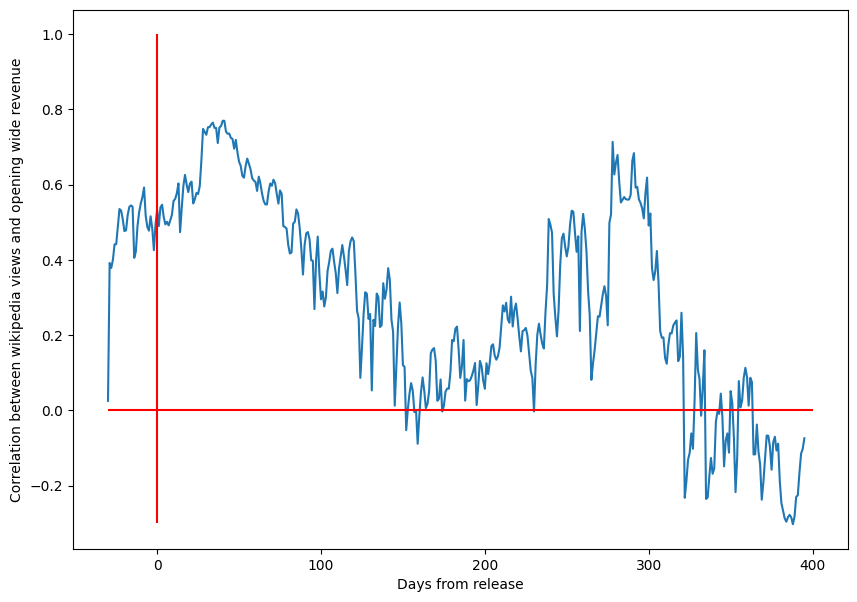

In [57]:
# group by day index and get the correlation between the two columns
# exclude non-numeric columns


numeric_corr_wdf = corr_wdf.select_dtypes(include=['number'])

correlation = numeric_corr_wdf.groupby('day_index').corr().loc[(slice(None), 'opening_wide_revenue'), 'views']

correlation_df = pd.DataFrame({'day_index': correlation.index.get_level_values(0), 'correlation': correlation.values})
correlation_df['day_index'] = correlation_df['day_index'] - 30
# plot the correlation
plt.figure(figsize=(10, 7))
sns.lineplot(data=correlation_df, x='day_index', y='correlation')
plt.vlines(x=0, ymin=-.3, ymax=1, color='red')
plt.hlines(y=0, xmin=-30, xmax=400, color='red')
plt.xlabel('Days from release')
plt.ylabel('Correlation between wikipedia views and opening wide revenue')